# Predict a possible heart disease

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import recall_score, roc_auc_score, f1_score, accuracy_score, precision_score, classification_report, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss 

## Load The Dataset

In [2]:
# Load The Dataset
data = pd.read_csv(r"D:\ML_Project\heart.csv")

In [3]:
# Basic Data Overview
print(data.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [4]:
# Checking for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [5]:
# Check for duplicate data
print(data.duplicated().sum())

0


In [6]:
# View basic information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


## Feature Engineering

In [7]:
# Define categorical and numerical columns
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [8]:
# Convert FastingBS to string (categorical type)
data['FastingBS'] = data['FastingBS'].astype(str)

In [9]:
# Verify the change
print(data['FastingBS'].dtypes)

object


In [10]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Apply one-hot encoding to the categorical columns
encoded_categorical = encoder.fit_transform(data[categorical_cols])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols), index=data.index)

# Drop the original categorical columns from the dataset
data.drop(columns=categorical_cols, inplace=True)

# Combine the encoded features with the original dataset
data = pd.concat([data, encoded_df], axis=1)

In [11]:
# Drop the target variable 'HeartDisease' and create a feature list
feature_list = data.drop(columns=['HeartDisease']).columns.tolist()

# Print the feature list
print("Feature List:", feature_list)

Feature List: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'FastingBS_0', 'FastingBS_1', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


In [12]:
# Initialize the standardization tool
scaler = StandardScaler()

# Standardize the numerical features
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


In [13]:
# Verify the results of standardization
print("\nNumerical columns mean and standard deviation after scaling:")
print("Means (should be approximately 0):")
print(data[numerical_cols].mean())
print("\nStandard deviations (should be approximately 1):")
print(data[numerical_cols].std())



Numerical columns mean and standard deviation after scaling:
Means (should be approximately 0):
Age           -1.083616e-16
RestingBP      1.954380e-16
Cholesterol    0.000000e+00
MaxHR          4.953675e-16
Oldpeak        1.238419e-16
dtype: float64

Standard deviations (should be approximately 1):
Age            1.000545
RestingBP      1.000545
Cholesterol    1.000545
MaxHR          1.000545
Oldpeak        1.000545
dtype: float64


In [14]:
# Final feature list
print("Final Feature List:")
print(feature_list)
# Display the first few rows of the processed data
print("Processed Training Data:")
print(data.head())

Final Feature List:
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'FastingBS_0', 'FastingBS_1', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
Processed Training Data:
        Age  RestingBP  Cholesterol     MaxHR   Oldpeak  HeartDisease  Sex_F  \
0 -1.433140   0.410909     0.825070  1.382928 -0.832432             0    0.0   
1 -0.478484   1.491752    -0.171961  0.754157  0.105664             1    1.0   
2 -1.751359  -0.129513     0.770188 -1.525138 -0.832432             0    0.0   
3 -0.584556   0.302825     0.139040 -1.132156  0.574711             1    1.0   
4  0.051881   0.951331    -0.034755 -0.581981 -0.832432             0    0.0   

   Sex_M  ChestPainType_ASY  ChestPainType_ATA  ...  FastingBS_0  FastingBS_1  \
0    1.0                0.0                1.0  ...          

## RandomForest Model

In [15]:
# Separate the target variable and features
X = data[feature_list]  # Select feature columns based on feature_list
y = data['HeartDisease']

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Use best parameters for optimizing Recall Rate
best_params_recall = {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

# Build the model
model_recall = RandomForestClassifier(
    max_depth=best_params_recall['max_depth'],
    max_features=best_params_recall['max_features'],
    min_samples_leaf=best_params_recall['min_samples_leaf'],
    min_samples_split=best_params_recall['min_samples_split'],
    n_estimators=best_params_recall['n_estimators'],
    random_state=42,
    class_weight='balanced'
)

# Train the model
model_recall.fit(X_train, y_train)

# Evaluate on the test set
y_pred_recall = model_recall.predict(X_test)
y_pred_proba_recall = model_recall.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_recall))

# Compute and print comprehensive metrics
accuracy = accuracy_score(y_test, y_pred_recall)
precision = precision_score(y_test, y_pred_recall)
recall = recall_score(y_test, y_pred_recall)
f1 = f1_score(y_test, y_pred_recall)
roc_auc = roc_auc_score(y_test, y_pred_proba_recall)

print("\nComprehensive Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89        82
           1       0.89      0.94      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184


Comprehensive Metrics:
Accuracy: 0.9022
Precision: 0.8889
Recall: 0.9412
F1 Score: 0.9143
ROC-AUC: 0.9307


# XGBoost Model

In [18]:
# Separate the target variable and features
X = data[feature_list]  # Select feature columns based on feature_list
y = data['HeartDisease']

In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Train the model using optimal parameters
best_params = {
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_child_weight': 1,
    'n_estimators': 50,
    'reg_alpha': 0,
    'reg_lambda': 10,
    'scale_pos_weight': 1,
    'subsample': 1.0
}

final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **best_params  # Unpack the best parameters
)

# Training model
final_model.fit(X_train, y_train)

# test model
y_pred_recall = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Output classification report
print("Classification Report for Recall Rate Optimized Model:")
print(classification_report(y_test, y_pred_recall))

# Calculate various indicators
accuracy = accuracy_score(y_test, y_pred_recall)
precision = precision_score(y_test, y_pred_recall)
recall = recall_score(y_test, y_pred_recall)
f1 = f1_score(y_test, y_pred_recall)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Output results
print("\nComprehensive Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Classification Report for Recall Rate Optimized Model:
              precision    recall  f1-score   support

           0       0.93      0.68      0.79        82
           1       0.79      0.96      0.87       102

    accuracy                           0.84       184
   macro avg       0.86      0.82      0.83       184
weighted avg       0.85      0.84      0.83       184


Comprehensive Metrics:
Accuracy: 0.8370
Precision: 0.7903
Recall: 0.9608
F1 Score: 0.8673
ROC-AUC: 0.9121


## SVM

In [21]:
# Separate the target variable and features
X = data[feature_list]  # Select feature columns based on feature_list
y = data['HeartDisease']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    recall_score, roc_auc_score, f1_score,
    accuracy_score, precision_score, classification_report
)

# Step 1: Define the SVM model with best parameters
svm = SVC(
    C=0.1,
    class_weight=None,
    coef0=0.1,
    degree=3,
    gamma='scale',
    kernel='poly',
    probability=True  # Required for ROC-AUC calculation
)

# Step 2: Create a pipeline with the SVM model
pipeline = make_pipeline(svm)

# Step 3: Evaluate using cross-validation (scoring by recall)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-Validation Recall Scores: {cv_scores}")
print(f"Mean Recall: {cv_scores.mean():.4f}")

# Step 4: Train the model on the training set
pipeline.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Step 6: Compute evaluation metrics
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("\nModel Evaluation Metrics on Test Set:")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

# Step 7: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Recall Scores: [0.93902439 0.92592593 0.91358025 0.87654321 0.91358025]
Mean Recall: 0.9137

Model Evaluation Metrics on Test Set:
Recall: 0.9314
ROC-AUC: 0.9364
F1-Score: 0.9135
Accuracy: 0.9022
Precision: 0.8962

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



# Logistic regression

In [23]:
# Separate the target variable and features
X = data[feature_list]  # Select feature columns based on feature_list
y = data['HeartDisease']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    recall_score, roc_auc_score, f1_score,
    accuracy_score, precision_score, classification_report
)
from sklearn.model_selection import train_test_split


# Step 1: Initialize Logistic Regression model
logreg = LogisticRegression(
    solver='liblinear',  # Good for small datasets or binary classification
    random_state=42
)

# Step 2: Train the model
logreg.fit(X_train, y_train)

# Step 3: Predict on test set
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Step 4: Compute evaluation metrics
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("\nModel Evaluation Metrics on Test Set:")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

# Step 5: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Model Evaluation Metrics on Test Set:
Recall: 0.9314
ROC-AUC: 0.9302
F1-Score: 0.9005
Accuracy: 0.8859
Precision: 0.8716

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



# Our MLOps Tool

## Step 1  Package Experiment Results 
   
Save your trained model (`model.pkl`), configuration (`config.json`), and evaluation metrics (`metrics.json`) into a versioned folder (e.g., `experiments/exp1/`).  

This helps organize and track your model experiments easily.


In [ ]:


from scripts.package_results import package_results

# For RandomForest model
from scripts.package_results import package_results
package_results(model_recall, X_test, y_test, dataset_name="random_forest_heart")

# For XGBoost model
package_results(final_model, X_test, y_test, dataset_name="xgboost_heart")

# For SVM model (extract the SVM from the pipeline)
svm_model = pipeline.named_steps['svc']  
package_results(svm_model, X_test, y_test, dataset_name="svm_heart")

# For Logistic Regression model
package_results(logreg, X_test, y_test, dataset_name="logreg_heart")

2025-04-10 15:11:01,036 - INFO - Saved model to experiments\exp1\model.pkl
2025-04-10 15:11:01,038 - INFO - Evaluating model on test data...


2025-04-10 15:11:01,086 - INFO - Saved metrics to experiments\exp1\metrics.json
2025-04-10 15:11:01,092 - INFO - Saved config to experiments\exp1\config.json
2025-04-10 15:11:01,094 - INFO - Successfully packaged model in exp1
2025-04-10 15:11:01,096 - INFO - config.json, metrics.json and model.pkl have been created
2025-04-10 15:11:01,106 - INFO - Saved model to experiments\exp2\model.pkl
2025-04-10 15:11:01,110 - INFO - Evaluating model on test data...
2025-04-10 15:11:01,162 - INFO - Saved metrics to experiments\exp2\metrics.json
2025-04-10 15:11:01,167 - INFO - Saved config to experiments\exp2\config.json
2025-04-10 15:11:01,169 - INFO - Successfully packaged model in exp2
2025-04-10 15:11:01,177 - INFO - config.json, metrics.json and model.pkl have been created
2025-04-10 15:11:01,183 - INFO - Saved model to experiments\exp3\model.pkl
2025-04-10 15:11:01,185 - INFO - Evaluating model on test data...
2025-04-10 15:11:01,216 - INFO - Saved metrics to experiments\exp3\metrics.json
20

'experiments\\exp4'

## Step2  Compare Multiple Experiments

Load and visualize results from all experiments, compare evaluation metrics (e.g., accuracy, F1-score), and get automatic recommendations on the best-performing model.

In [ ]:
from scripts.compare_metrics import run_compare_metrics 



Metrics Comparison:
      accuracy  f1_score  precision    recall     confusion_matrix  loss  \
exp1  0.902174  0.901714   0.903223  0.902174  [[70, 12], [6, 96]]   0.0   
exp2  0.836957  0.832262   0.854056  0.836957  [[56, 26], [4, 98]]   0.0   
exp3  0.902174  0.901892   0.902479  0.902174  [[71, 11], [7, 95]]   0.0   
exp4  0.885870  0.885218   0.887205  0.885870  [[68, 14], [7, 95]]   0.0   

                       timestamp  
exp1  2025-04-10T15:11:01.084072  
exp2  2025-04-10T15:11:01.161628  
exp3  2025-04-10T15:11:01.213639  
exp4  2025-04-10T15:11:01.253173  



Recommendations:
- exp1: Good performance (accuracy: 0.9022) (BEST MODEL)
- exp2: Average performance (accuracy: 0.8370)
- exp3: Good performance (accuracy: 0.9022)
- exp4: Average performance (accuracy: 0.8859)
- summary: RECOMMENDATION: Model 'exp1' is the best performer with accuracy = 0.9022


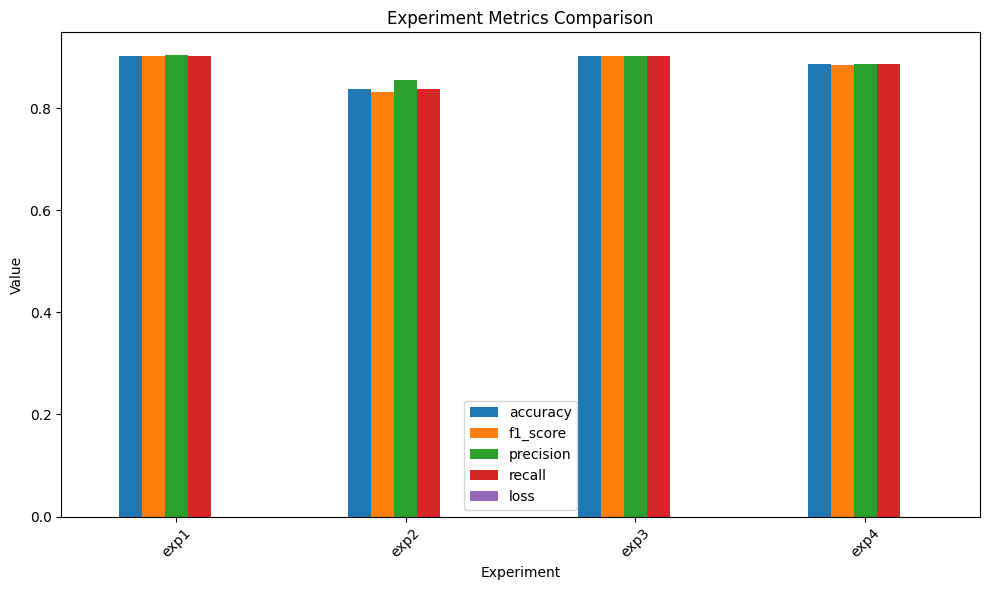

In [39]:
metrics_df_acc, recommendations_acc, fig_acc = run_compare_metrics(
    metrics_dir="experiments",
    configs_dir="experiments",
    save_path=None,                   
    priority_metric="accuracy"       # Specify the priority_metricd as accuracy
)



Metrics Comparison:
      accuracy  f1_score  precision    recall     confusion_matrix  loss  \
exp1  0.902174  0.901714   0.903223  0.902174  [[70, 12], [6, 96]]   0.0   
exp2  0.836957  0.832262   0.854056  0.836957  [[56, 26], [4, 98]]   0.0   
exp3  0.902174  0.901892   0.902479  0.902174  [[71, 11], [7, 95]]   0.0   
exp4  0.885870  0.885218   0.887205  0.885870  [[68, 14], [7, 95]]   0.0   

                       timestamp  
exp1  2025-04-10T15:11:01.084072  
exp2  2025-04-10T15:11:01.161628  
exp3  2025-04-10T15:11:01.213639  
exp4  2025-04-10T15:11:01.253173  



Recommendations:
- exp1: Good performance (f1_score: 0.9017)
- exp2: Average performance (f1_score: 0.8323)
- exp3: Good performance (f1_score: 0.9019) (BEST MODEL)
- exp4: Average performance (f1_score: 0.8852)
- summary: RECOMMENDATION: Model 'exp3' is the best performer with f1_score = 0.9019


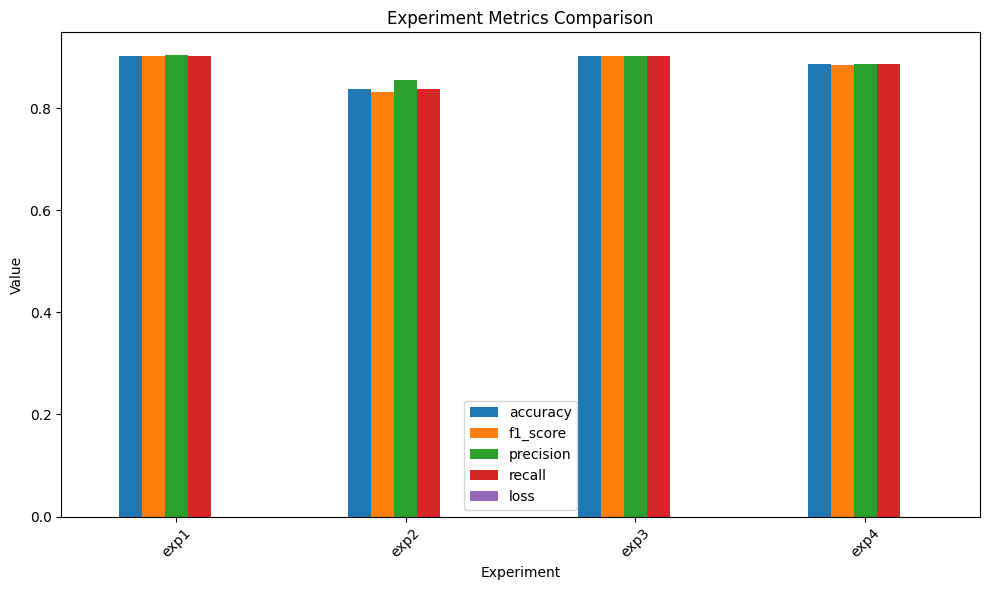

In [40]:
metrics_df_f1, recommendations_f1, fig_f1 = run_compare_metrics(
    metrics_dir="experiments",
    configs_dir="experiments",
    save_path=None,                   
    priority_metric="f1_score"   # Specify the priority_metricd as f1_score   
)


## Step3 Launch Streamlit Dashboard

Launch an interactive dashboard to view experiment results, metric charts, and system recommendations — all in your browser.

In [ ]:
from scripts.run_dashboard import run_dashboard_ui

In [28]:
run_dashboard_ui()